# > **ODE:**
$$\frac{d^2 x}{d t^2}+\mu\frac{d x}{d t}+kx=0 $$

,where $ \mu=2m\delta, k = m\omega^2$

Condition: $x(0)=1, \frac{d x}{d t}(0)=0, m=1$


# > **Solution**
$$x(t)=2A e^{-\delta t} cos(\phi + \omega t)$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image

USE_GPU = True
dtype = torch.float64

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


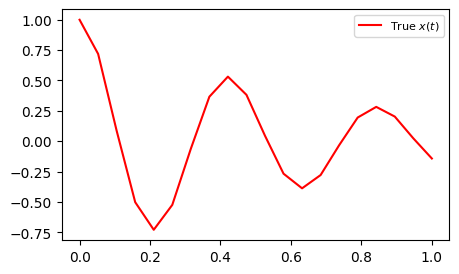

In [2]:
# https://beltoforion.de/en/harmonic_oscillator/
def oscillator(delta, omega0, t):
    assert delta < omega0
    omega   = np.sqrt(omega0**2 - delta**2)
    phi     = np.arctan(-delta/omega)
    A       = 1/(2*np.cos(phi))
    return torch.exp(-delta * t)*2*A*torch.cos(phi+omega*t)

N_grid, delta, omega0 =20, 1.5, 15
mu_real, k_real = 2*delta, omega0**2        ## mass = 1

t_grid  = torch.linspace(0, 1, N_grid).view(-1,1)
x_grid  = oscillator(delta, omega0, t_grid).view(-1,1)

N_obs = 15
# idx     = np.random.choice(np.arange(len(t_grid)), replace=0, size=N_obs)
# t_obs   = t_grid[idx]
# x_obs   = x_grid[idx]

NOISE = True
# if NOISE:
    # x_obs += torch.rand(x_obs.size())*0.1

figure = plt.figure(figsize=(5,3))
plt.plot(t_grid, x_grid, color='r', label='True $x(t)$')
# plt.scatter(t_obs, x_obs, marker='o',label='Observed $x(t)$')
plt.legend(fontsize=8)

# t_obs, x_obs             = t_obs.to(device).requires_grad_(True), x_obs.to(device)
t_grid, x_grid           = t_grid.to(device).requires_grad_(True), x_grid.to(device)
t_init, x_init, dx_init  = torch.zeros([1,1]).to(device).requires_grad_(True), torch.ones([1,1]).to(device), torch.zeros([1,1]).to(device)

# k   = torch.ones(1).to(device).requires_grad_(True)
# mu  = torch.ones(1).to(device).requires_grad_(True)

In [3]:
model = nn.Sequential(nn.Linear(1,64),
                      nn.Tanh(),
                      nn.Linear(64, 64),
                      nn.Tanh(),
                      nn.Linear(64, 64),
                      nn.Tanh(),
                      nn.Linear(64, 64),
                      nn.Tanh(),
                      nn.Linear(64, 1))
model = model.to(device)

loss_f = nn.MSELoss()
optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.001)

scheduler = None
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20000], gamma=2)

In [4]:
def derivative(y, t) :
    return torch.autograd.grad(y, t, create_graph=True, grad_outputs=torch.ones(y.size()).to(device))[0]

In [5]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)
def plot_result(x,y,yh):
    "Pretty plot training results"
    plt.figure(figsize=(8,5))
    plt.plot(x,y, color="gray", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x, y, marker="s", color="r", alpha=0.4, label='Gradient point')
    plt.legend(loc='lower right')
    plt.xlabel("Time", size=20)
    plt.ylabel("Displacement", size=20)
    plt.xlim(-0.05, 1.05)
    plt.xlim(-0., 1.)
    plt.ylim(-1.1, 1.1)
    plt.text(.6,0.8,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    # plt.axis("off")

In [ ]:
history_loss = []

best_model=None
best_k, best_mu, best_loss = 0, 0, 100

# Train
model.train()

EPOCHS = 60000
files = []
for i in range(1, EPOCHS+1) :
    optimizer.zero_grad()

    output      = model(t_grid)                         # x(t)
    output_init = model(t_init)                         # x(t_init)
    # output_obs  = model(t_obs)                          # x(t_obs)

    doutput     = derivative(output, t_grid)            # dx/dt(t)
    d2output    = derivative(doutput, t_grid)           # dx/dt(t)
    doutput_init= derivative(output_init, t_init)       # dx/dt(t_init)

    # # For general case, use below.
    # loss_init   = loss_f(output_init, x_init) + loss_f(doutput_init, dx_init) / 2                       # Loss for initial conditions
    # loss_obs    = loss_f(output_obs, x_obs) / N_obs                                                     # Loss for observed data
    # loss_ge     = loss_f(d2output + mu*doutput + k*output, torch.zeros_like(doutput)) / N_grid          # Loss for ODE

    ## Original version. Not good for noisy case
    # loss_init   = loss_f(output_init, x_init) + loss_f(doutput_init, dx_init)                         # Loss for initial conditions
    # loss_obs    = loss_f(output_obs, x_obs)                                                           # Loss for observed data
    # loss_ge     = loss_f(d2output + mu*doutput + k*output, torch.zeros_like(doutput))*(1.0e-4)        # Loss for ODE

    # Importance of ODS loss will be increase as epochs proceeds (For noisy case)
    loss_init   = loss_f(output_init, x_init) + loss_f(doutput_init, dx_init)                        # Loss for initial conditions
    # loss_obs    = loss_f(output_obs, x_obs)                                                           # Loss for observed data
    loss_ge     = loss_f(d2output + mu_real*doutput + k_real*output, torch.zeros_like(doutput))              # Loss for ODE

    loss        = loss_init + loss_ge*0.1
    loss.backward()

    optimizer.step()
    if scheduler != None:
        scheduler.step()

    history_loss.append(loss.item())
    # history_mu.append(mu.item())
    # history_k.append(k.item())

    if loss.item() < best_loss:
        best_model = model
        best_loss = loss.item()

    if not i % 1000 :
        print('EPOCH : %6d/%6d | Loss_ge : %8.7f | Loss_init : %8.7f '\
              %(i, EPOCHS, loss_ge.item(), loss_init.item()))

    if (i+1) %1000== 0:
        file = "plots/pinn_%.8i.png"%(i+1)
        files.append(file)
        plot_result(t_grid.cpu().detach(),x_grid.cpu().detach(), output.cpu().detach())
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
save_gif_PIL("result/pinn.gif", files, fps=20, loop=0)

print('Training Finished.')

EPOCH :   1000/ 60000 | Loss_ge : 0.0163098 | Loss_init : 0.9964541 
EPOCH :   2000/ 60000 | Loss_ge : 0.0182336 | Loss_init : 0.9961882 
EPOCH :   3000/ 60000 | Loss_ge : 0.0183996 | Loss_init : 0.9961532 
EPOCH :   4000/ 60000 | Loss_ge : 0.0186649 | Loss_init : 0.9961022 
EPOCH :   5000/ 60000 | Loss_ge : 0.0187010 | Loss_init : 0.9960828 
EPOCH :   6000/ 60000 | Loss_ge : 0.0187809 | Loss_init : 0.9960617 
EPOCH :   7000/ 60000 | Loss_ge : 0.0189493 | Loss_init : 0.9960195 
EPOCH :   8000/ 60000 | Loss_ge : 0.0176069 | Loss_init : 0.9961473 
EPOCH :   9000/ 60000 | Loss_ge : 0.0197819 | Loss_init : 0.9958127 
EPOCH :  10000/ 60000 | Loss_ge : 0.0183727 | Loss_init : 0.9962666 
EPOCH :  11000/ 60000 | Loss_ge : 0.0190519 | Loss_init : 0.9960473 
EPOCH :  12000/ 60000 | Loss_ge : 0.0197336 | Loss_init : 0.9957627 
EPOCH :  13000/ 60000 | Loss_ge : 0.0216128 | Loss_init : 0.9951971 
EPOCH :  14000/ 60000 | Loss_ge : 0.0264568 | Loss_init : 0.9938987 
EPOCH :  15000/ 60000 | Loss_ge : 

In [ ]:
# View data
figure = plt.figure(figsize=(5,3))
plt.plot(t_grid.cpu().detach(), x_grid.cpu().detach(), color='k', linestyle='--', label='True $x(t)$')
# plt.plot(t_grid.cpu().detach(), best_model(t_grid).cpu().detach(), color='r', label='PINN $x(t)$') # For best model
plt.plot(t_grid.cpu().detach(), model(t_grid).cpu().detach(), color='r', label='PINN $x(t)$')        # For final model
#plt.scatter(t_obs.cpu().detach(), x_obs.cpu().detach(), marker='o',label='Observed $x(t)$')
plt.legend(fontsize=8)

In [ ]:
figure = plt.figure(figsize=(15,5))
ax1 = figure.add_subplot(1,3,1)
ax1.plot(history_mu)
ax1.set_title('$\mu$')
ax1.set_xlabel('epoch')
ax1.hlines(mu_real, 0, EPOCHS, color='k',linestyle='--', label='True $\mu$')
# ax1.hlines(best_mu, 0, EPOCHS, color='r', label='Best $\mu$') # For best model
ax1.legend()

ax2 = figure.add_subplot(1,3,2)
ax2.plot(history_k)
ax2.set_title('k')
ax2.set_xlabel('epoch')
ax2.hlines(k_real, 0, EPOCHS, color='k', linestyle='--', label='True k')
# ax2.hlines(best_k, 0, EPOCHS, color='r', label='Best k') # For best model
ax2.legend()

ax3 = figure.add_subplot(1,3,3)
ax3.plot(history_loss, label='Training Loss')
ax3.set_yscale('log')
ax3.legend()
ax3.set_title('Training Loss in log scale', fontsize=13)
ax3.set_xlabel('epoch', fontsize=13)